# LOGISTIC PERFORMANCE ANALYSIS

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [42]:
orders = pd.read_csv('olist_orders_dataset.csv',delimiter=',')
customers = pd.read_csv('olist_customers_dataset.csv',delimiter=',')
print(orders.head())
print('-'*100)
print(customers.head())


                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08

In [43]:
#data merging 
# we have 2 seperate files, orders and customers that have a common column customer_id
df_logistic = orders.merge(customers, on='customer_id', how='left')

print(orders.shape)
print('-'*100)
print(df_logistic.shape)
print('-'*100)
print(df_logistic.columns)
print('-'*100)
print(df_logistic.head())

(99441, 8)
----------------------------------------------------------------------------------------------------
(99441, 12)
----------------------------------------------------------------------------------------------------
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')
----------------------------------------------------------------------------------------------------
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7

#### Data Cleaning & Data Typecasting

In [44]:
df_logistic.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
 8   customer_unique_id             99441 non-null  object
 9   customer_zip_code_prefix       99441 non-null  int64 
 10  customer_city                  99441 non-null  object
 11  customer_state                 99441 non-null  object
dtypes: int64(1), object(11)
memory usage: 9.1+ MB


In [45]:
date_cols = ['order_delivered_customer_date','order_estimated_delivery_date']

for col in date_cols:
    df_logistic[col] = pd.to_datetime(df_logistic[col])


In [46]:
df_logistic.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [47]:
# menghapus data (Nan) pada kolom order estimated delivery date
# untuk mengetahui jumlah data yang hilang pada kolom order estimated delivery date setelah di hapus
df_logistic_clean = df_logistic.dropna(subset=['order_estimated_delivery_date','order_delivered_customer_date'])
print(df_logistic_clean['order_estimated_delivery_date'].isnull().sum())
print(df_logistic_clean['order_delivered_customer_date'].isnull().sum())
print('-' * 100)
print(df_logistic_clean.shape)
print('-' * 100)
print(df_logistic_clean.info())

0
0
----------------------------------------------------------------------------------------------------
(96476, 12)
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 96476 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96476 non-null  object        
 1   customer_id                    96476 non-null  object        
 2   order_status                   96476 non-null  object        
 3   order_purchase_timestamp       96476 non-null  object        
 4   order_approved_at              96462 non-null  object        
 5   order_delivered_carrier_date   96475 non-null  object        
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96476 non-null  datetime64[ns]
 8   cus

In [49]:
# membuat kolom baru untuk menghitung selisih hari antara tanggal pengiriman yang diestimasikan dan tanggal pengiriman aktual
# Kita ambil '.dt.days' untuk mendapatkan angkanya saja (integer)
df_logistic_clean['delivery_delay'] = (df_logistic_clean['order_delivered_customer_date'] - df_logistic_clean['order_estimated_delivery_date']).dt.days

df_logistic_clean.head(5)

C:\Users\Bintang Purnama\AppData\Local\Temp\ipykernel_16784\1484615419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logistic_clean['delivery_delay'] = (df_logistic_clean['order_delivered_customer_date'] - df_logistic_clean['order_estimated_delivery_date']).dt.days


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_delay
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-6
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-18
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,-13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,-10


In [50]:
#mengambil insight bisinis dari data selisih hari pengiriman
#Group by state , lalu hitung rata-rata delay 
delay_by_state = df_logistic_clean.groupby('customer_state')['delivery_delay'].mean().reset_index()

print(delay_by_state.sort_values(by='delivery_delay',ascending=False))

   customer_state  delivery_delay
1              AL       -8.707809
9              MA       -9.571827
24             SE      -10.020896
7              ES      -10.496241
4              BA      -10.794533
5              CE      -10.804535
11             MS      -11.052782
25             SP      -11.076380
16             PI      -11.306723
23             SC      -11.508317
18             RJ      -11.766858
6              DF      -12.048077
26             TO      -12.131387
8              GO      -12.185488
10             MG      -13.240775
14             PB      -13.261122
15             PE      -13.293785
17             PR      -13.314239
19             RN      -13.649789
22             RS      -13.910367
13             PA      -14.066596
12             MT      -14.363431
21             RR      -17.292683
2              AM      -19.565517
3              AP      -19.686567
20             RO      -20.102881
0              AC      -20.725000


# Business Decision Recomendation and Conclusion  
Tindakan: Tim Tech harus memperbarui algoritma estimasi (terutama untuk state AC, RO, AP, AM) agar lebih agresif/realistis.

Target: Kurangi "Gap" (selisih). Idealnya, rata-rata delay itu mendekati 0 atau -1/-2 hari saja (sampai 1-2 hari lebih cepat itu delightful, tapi kalau 20 hari lebih cepat itu inefficient planning).

Tujuan: Meningkatkan Conversion Rate (orang jadi berani beli karena estimasi pengirimannya terlihat cepat).

# Visualization

C:\Users\Bintang Purnama\AppData\Local\Temp\ipykernel_16784\379557862.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_delivery_delay',y='customer_state',data=delay_by_state ,palette='viridis')


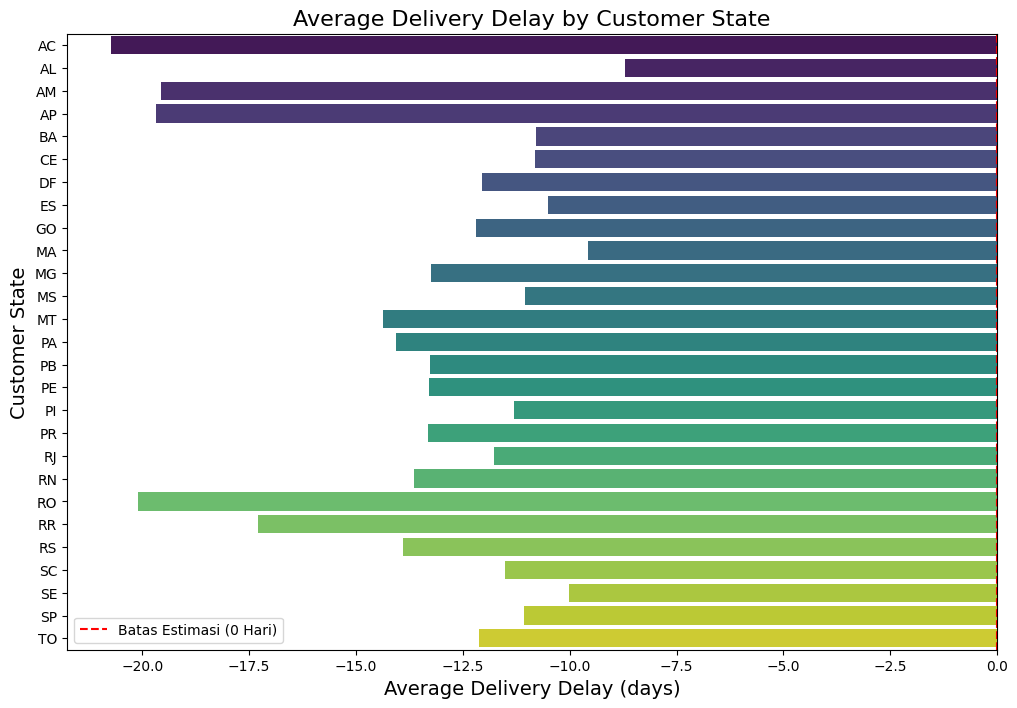

In [52]:
delay_by_state.columns = ['customer_state','avg_delivery_delay']

plt.figure(figsize=(12,8))

sns.barplot(x='avg_delivery_delay',y='customer_state',data=delay_by_state ,palette='viridis')

plt.title('Average Delivery Delay by Customer State',fontsize=16)
plt.xlabel('Average Delivery Delay (days)',fontsize=14)
plt.ylabel('Customer State',fontsize=14)

plt.axvline(x=0, color='red', linestyle='--', label='Batas Estimasi (0 Hari)')
plt.legend()

plt.show()